In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Import Libraries

In [2]:
import re
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm
tqdm.pandas()

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/language.csv')
data

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch
...,...,...
21995,hors du terrain les années et sont des année...,French
21996,ใน พศ หลักจากที่เสด็จประพาสแหลมมลายู ชวา อินเ...,Thai
21997,con motivo de la celebración del septuagésimoq...,Spanish
21998,年月，當時還只有歲的她在美國出道，以mai-k名義推出首張英文《baby i like》，由...,Chinese


# 3. Initial Analysis

### 3.1. Metadata

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      22000 non-null  object
 1   language  22000 non-null  object
dtypes: object(2)
memory usage: 343.9+ KB


In [6]:
data['language'].value_counts()

Estonian      1000
Swedish       1000
English       1000
Russian       1000
Romanian      1000
Persian       1000
Pushto        1000
Spanish       1000
Hindi         1000
Korean        1000
Chinese       1000
French        1000
Portugese     1000
Indonesian    1000
Urdu          1000
Latin         1000
Turkish       1000
Japanese      1000
Dutch         1000
Tamil         1000
Thai          1000
Arabic        1000
Name: language, dtype: int64

In [7]:
data.isnull().sum()

Text        0
language    0
dtype: int64

[Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000'),
 Text(0, 0, '1000')]

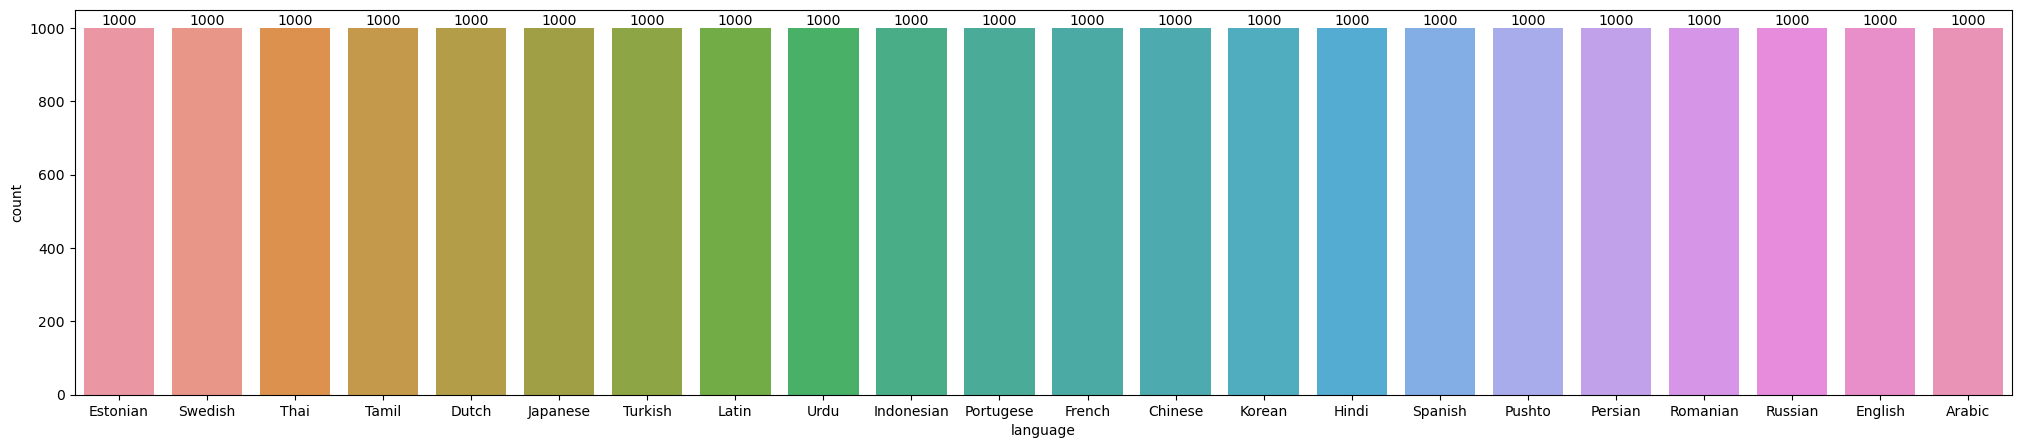

In [8]:
plt.subplots(figsize = (25,5))
ax = sns.countplot(data, x = data['language'])
ax.bar_label(ax.containers[0])

### 3.2. Processing Columns

In [4]:
def lower_text(text):
    return text.lower()

def alphanumeric_text(text):
    # return re.sub("[^a-z0-9\s]","", text)
    text = text.lower()
    return re.sub(r'[^\w\s.,]', '', text)

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\w\s.,]', '', text)
    text = [word for word in text.split(' ') if word not in nltk_stopword]
    text = " ".join(text)
    # text = [stemmer.stem(word) for word in text.split(' ')]
    # text=" ".join(text)
    return text
lemmatizer = WordNetLemmatizer()

def lemmatize_word(word):
    return lemmatizer.lemmatize(word, pos='v')

def lemmatize_sentence(sentence):
    words = nltk.word_tokenize(sentence)  # convert to lower case and tokenize
    words = [word for word in words if word.isalnum()]  # filter out non-alphanumeric characters
    words = [lemmatize_word(word) for word in words]  # lemmatize each word
    return ' '.join(words)  # join the lemmatized words back into a sentence


stopword_en = pd.read_csv('../../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

In [5]:
data['clean_text'] = data['Text'] \
                    .progress_apply(alphanumeric_text) \
                    .progress_apply(lemmatize_sentence) \
                    # .progress_apply(clean) \
                    # .progress_apply(remove_duplicate_words) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (nltk_stopword)])) \
                    # .progress_apply(lower_text) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if len(word) >= 4])) \
                    # .progress_apply(lemmatizer) \
data.head()

  0%|          | 0/2838 [00:00<?, ?it/s]

  0%|          | 0/2838 [00:00<?, ?it/s]

,text,label,clean_text
0,"He said he had not felt that way before, sugge...",1,he say he have not felt that way before sugget...
1,"Hey there r/assistance, Not sure if this is th...",0,hey there rassistance not sure if this be the ...
2,My mom then hit me with the newspaper and it s...,1,my mom then hit me with the newspaper and it s...
3,"until i met my new boyfriend, he is amazing, h...",1,until i meet my new boyfriend he be amaze he b...
4,October is Domestic Violence Awareness Month a...,1,october be domestic violence awareness month a...


<Axes: xlabel='text_len'>

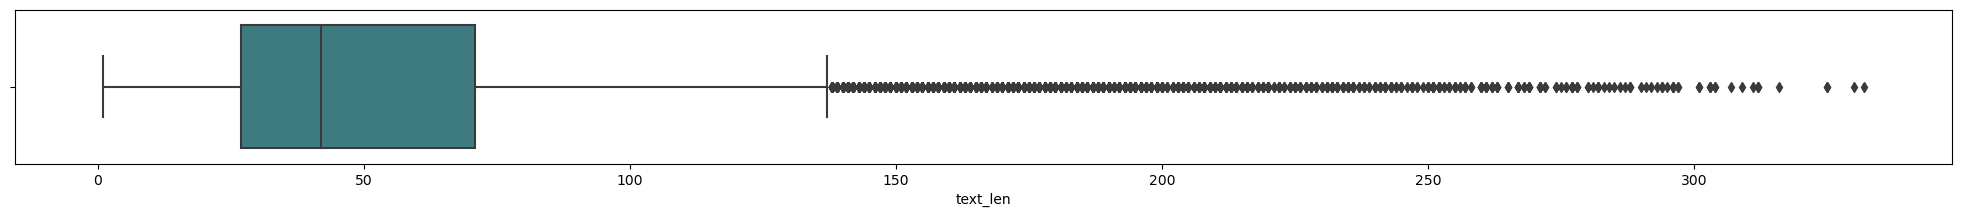

In [9]:
text_len = [len(word) for word in data['Text'].str.split(' ')]
data['text_len'] = pd.DataFrame(text_len)

fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="crest")

In [10]:
print(data['text_len'].quantile(0.1))
print(data['text_len'].quantile(1))

12.0
332.0


<Axes: xlabel='text_len'>

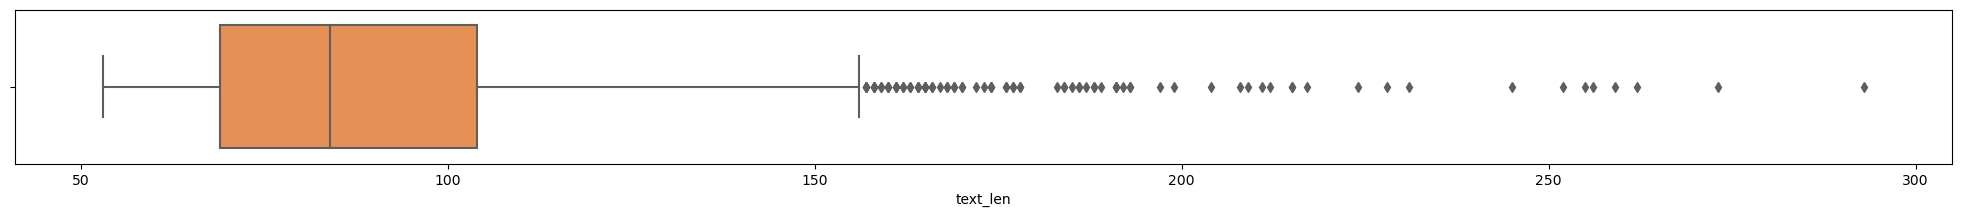

In [8]:
Q1 = data['text_len'].quantile(0.1)
Q3 = data['text_len'].quantile(1)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x = data['text_len'], palette="Oranges")

[Text(0, 0, '1201'), Text(0, 0, '1348')]

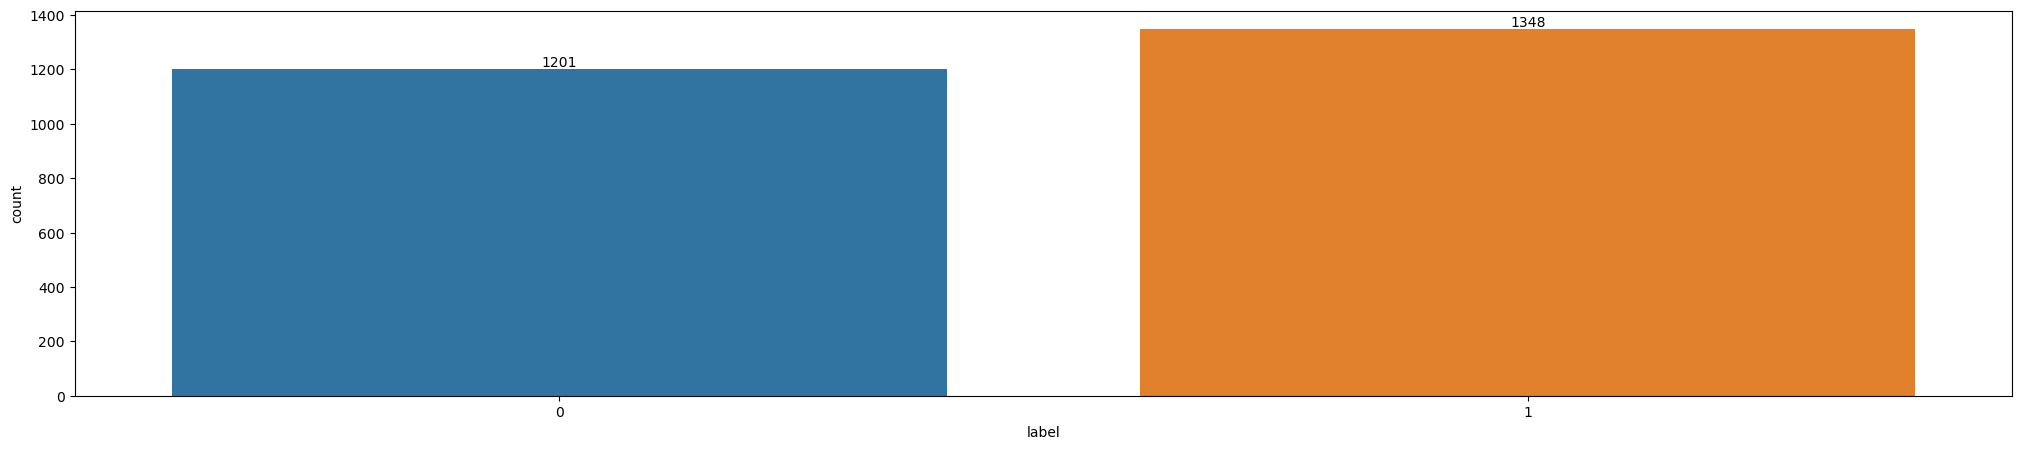

In [9]:
plt.subplots(figsize = (25,5))
ax = sns.countplot(data, x = data['label'])
ax.bar_label(ax.containers[0])

# 4. Preparing Dataset

In [4]:
LE = LabelEncoder()

X = data['Text']
# Y = LE.fit_transform(data['label']) ### For Classification Algoritms
# Y = pd.get_dummies(data['language']) ### For Deep Learning Algoritms
Y = data['language'] ### For Deep Learning Algoritms

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(15444,)
(4356,)
(2200,)


In [5]:
vocab_size = 10000
embedding_dim = 128
max_length = 333
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [6]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

273968


In [ ]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)


# 5. Deep Learning Model

In [20]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    return model


def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Bidirectional(LSTM(256)))
    model.add(Dense(2, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    # model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(22, activation='softmax'))
    return model

# model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

opt = Adam(learning_rate = 0.001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 333, 128)          1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 512)              592896    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 22)                11286     
                                                                 
Total params: 1,884,182
Trainable params: 1,884,182
Non-trainable params: 0
_________________________________________________________________


In [21]:
num_epoch = 10
batch_size = 32
history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (validating_padded, validating_label))

Epoch 1/10
483/483 [==============================] - 34s 64ms/step - loss: 1.1360 - accuracy: 0.6382 - val_loss: 0.2932 - val_accuracy: 0.8977
Epoch 2/10
483/483 [==============================] - 30s 63ms/step - loss: 0.1959 - accuracy: 0.9239 - val_loss: 0.2067 - val_accuracy: 0.9314
Epoch 3/10
483/483 [==============================] - 31s 64ms/step - loss: 0.1445 - accuracy: 0.9375 - val_loss: 0.1971 - val_accuracy: 0.9218
Epoch 4/10
483/483 [==============================] - 30s 61ms/step - loss: 0.1157 - accuracy: 0.9437 - val_loss: 0.1901 - val_accuracy: 0.9241
Epoch 5/10
483/483 [==============================] - 30s 62ms/step - loss: 0.1000 - accuracy: 0.9483 - val_loss: 0.1949 - val_accuracy: 0.9259
Epoch 6/10
483/483 [==============================] - 31s 64ms/step - loss: 0.0988 - accuracy: 0.9499 - val_loss: 0.2074 - val_accuracy: 0.9309
Epoch 7/10
483/483 [==============================] - 30s 63ms/step - loss: 0.0917 - accuracy: 0.9509 - val_loss: 0.2063 - val_accuracy:

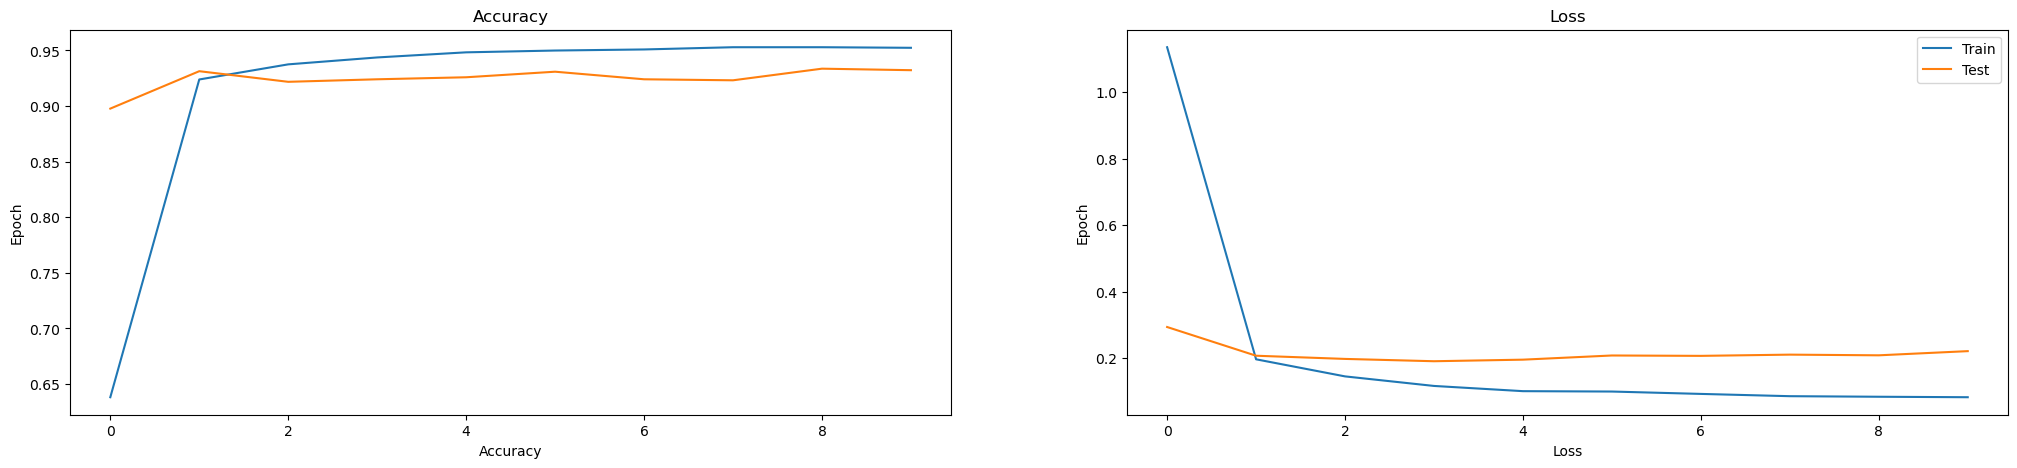

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [40]:
train_predictions = model.predict(testing_padded, verbose=0).argmax(axis=1).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label.argmax(axis=1)})
train_results['Diff'] = train_results['Actuals'] == train_results['Train Predictions']
print(train_results.head(5))
train_results['Diff'].value_counts()

   Train Predictions  Actuals   Diff
0                 11       11   True
1                  7        7   True
2                  1        8  False
3                 18       18   True
4                  6        6   True


True     4055
False     301
Name: Diff, dtype: int64

In [41]:
y_pred = np.rint(model.predict(testing_padded, verbose=0))
print(classification_report(testing_label,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       187
           1       0.48      0.84      0.61       186
           2       0.98      0.98      0.98       186
           3       0.90      0.99      0.95       196
           4       0.97      0.94      0.96       205
           5       0.97      0.99      0.98       195
           6       1.00      0.98      0.99       212
           7       1.00      0.99      0.99       206
           8       0.62      0.05      0.09       209
           9       1.00      0.98      0.99       176
          10       0.92      0.96      0.94       206
          11       1.00      1.00      1.00       206
          12       0.99      0.98      0.98       207
          13       0.98      0.95      0.97       207
          14       0.99      0.97      0.98       204
          15       0.97      1.00      0.98       159
          16       0.99      0.99      0.99       198
          17       1.00    

c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


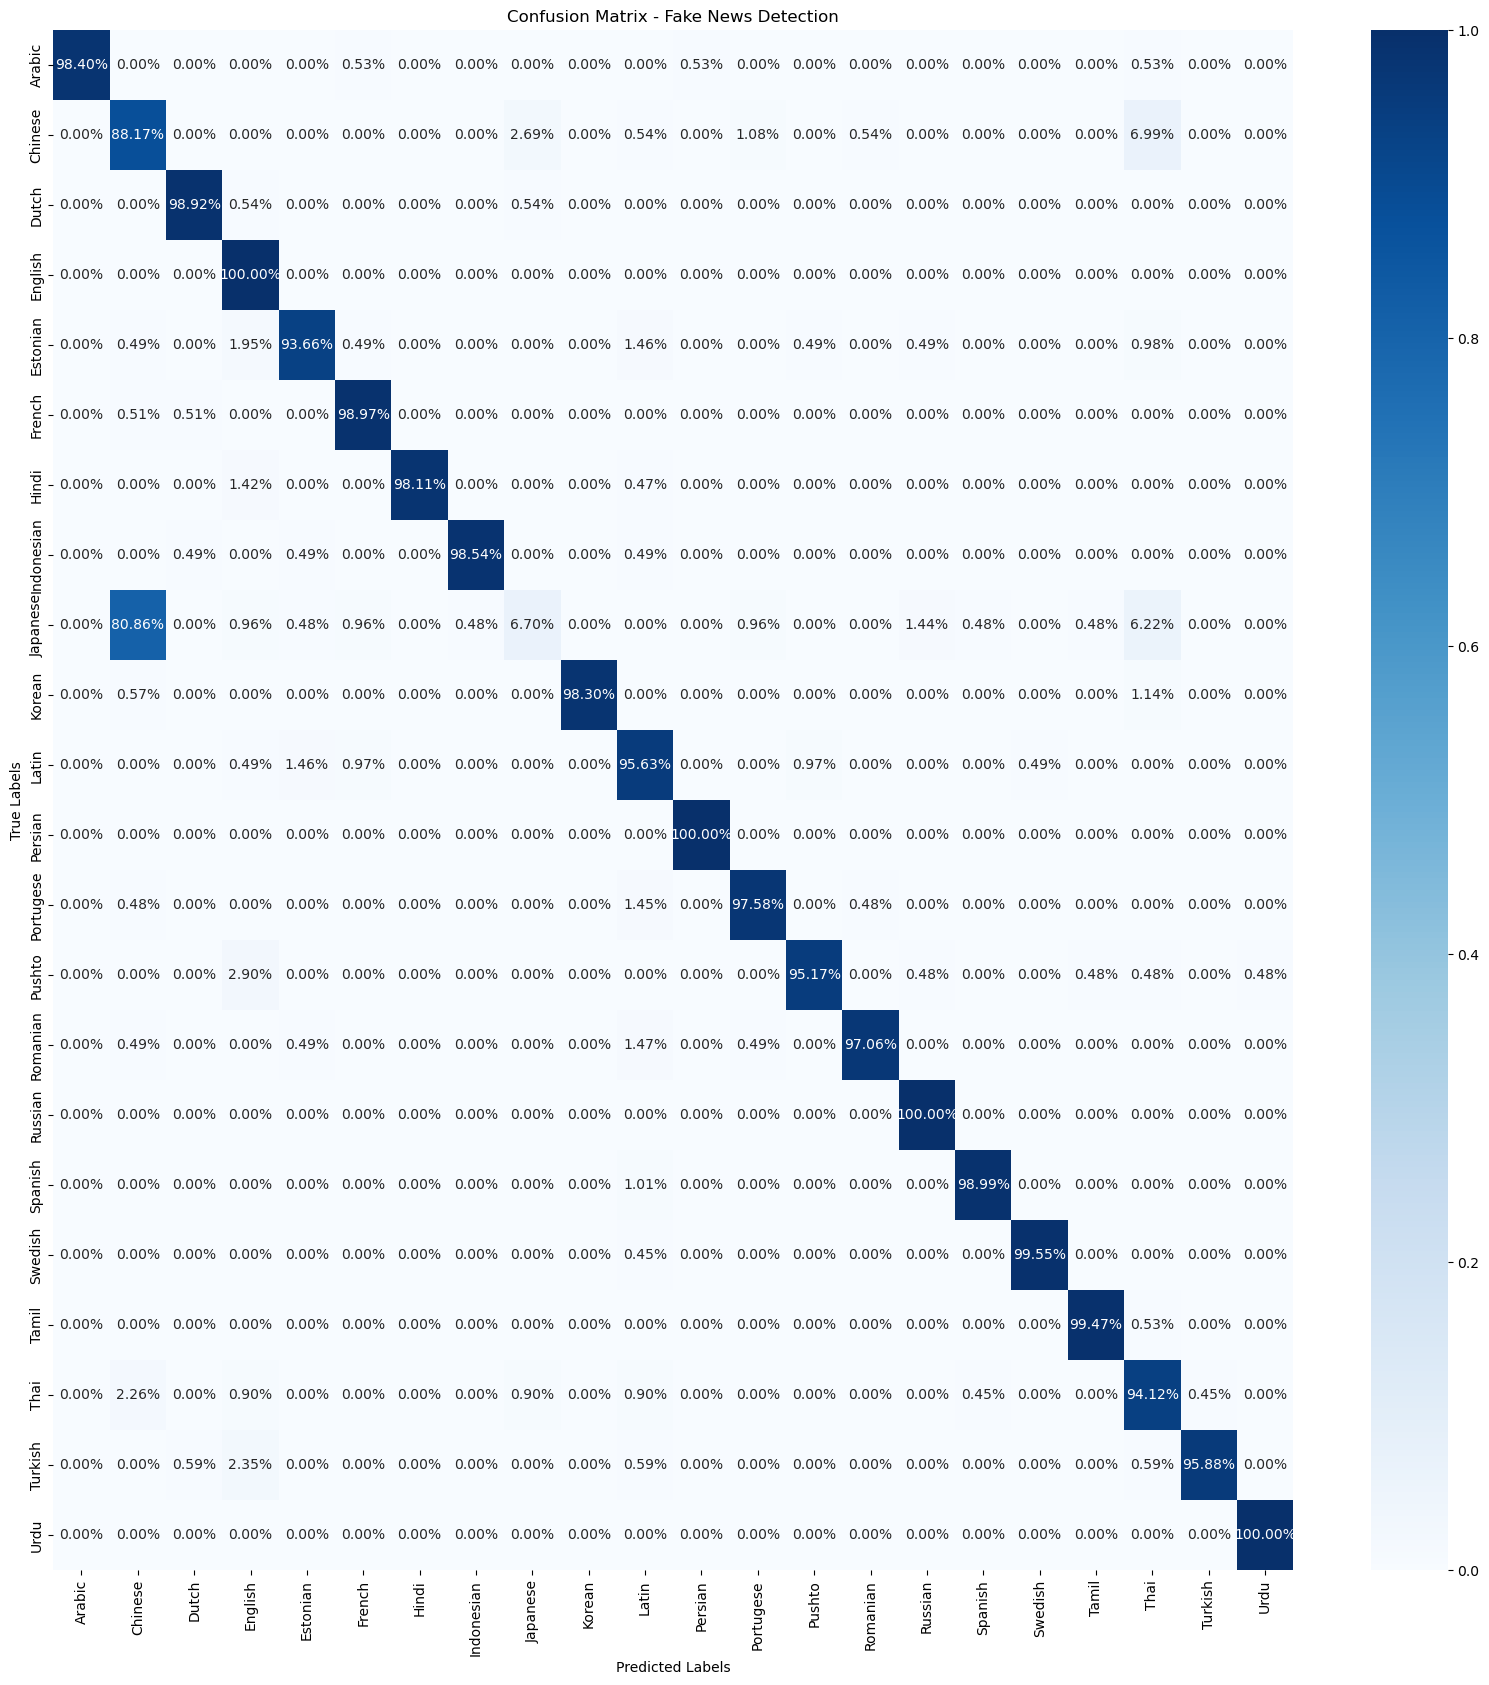

In [52]:
labels = ['Arabic', 'Chinese', 'Dutch', 'English', 'Estonian', 'French', 'Hindi',
       'Indonesian', 'Japanese', 'Korean', 'Latin', 'Persian', 'Portugese',
       'Pushto', 'Romanian', 'Russian', 'Spanish', 'Swedish', 'Tamil', 'Thai',
       'Turkish', 'Urdu']

y_pred = model.predict(testing_padded, verbose=0).argmax(axis=1)
con_mat = confusion_matrix(testing_label.argmax(axis=1),y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

plt.subplots(figsize=(20,20))
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

# 6. Classification Algoritms

In [7]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)
mnb = MultinomialNB()

model = StackingClassifier([
    # ('XGB', XGB),
    # ('randomforest', randomForest),
    # ('histGradientBoosting', histGradientBoosting),
    # ('adaboost', adaboost),
    # ('bagging', bagging),
    # ('extraTres', extraTrees),
    # ('knn', knn),
    # ('decisionTree', decisionTree),
    # ('gradient', gradient),
    ('mnb', mnb),

], n_jobs=-1)

In [8]:
model.fit(training_padded, training_label)

c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('mnb', MultinomialNB())], n_jobs=-1)

In [9]:
print("Train Score        :",round((model.score(training_padded, training_label)*100), 2),'%')
print("Test Score         :",round((model.score(testing_padded, testing_label)*100), 2),'%')

y_pred = model.predict(testing_padded)

print("R Squared Error    :",round(r2_score(testing_label, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(testing_label, y_pred), 2))

Train Score        : 12.66 %
Test Score         : 12.3 %


ValueError: could not convert string to float: 'Persian'

In [99]:
train_predictions = model.predict(testing_padded).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].sum(), '/', len(train_results['Diff']))

   Train Predictions  Actuals  Diff
0                  1        0     1
1                  1        1     0
2                  1        1     0
3                  0        0     0
4                  0        1     1
209 / 502


In [100]:
y_pred = model.predict(testing_padded)
print(classification_report(y_pred,testing_label))

              precision    recall  f1-score   support

           0       0.50      0.54      0.52       209
           1       0.65      0.62      0.63       293

    accuracy                           0.58       502
   macro avg       0.58      0.58      0.58       502
weighted avg       0.59      0.58      0.59       502



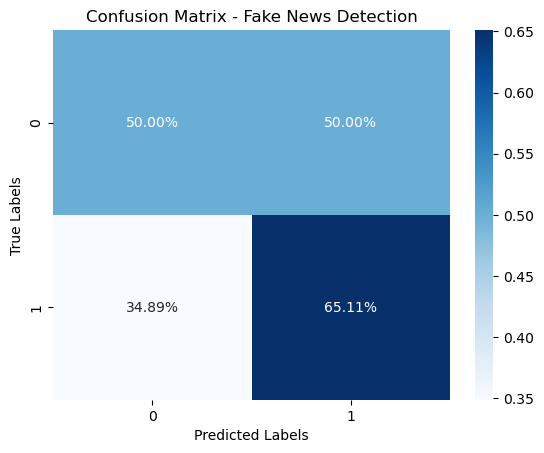

In [101]:
labels = ['Arabic', 'Chinese', 'Dutch', 'English', 'Estonian', 'French', 'Hindi',
            'Indonesian', 'Japanese', 'Korean', 'Latin', 'Persian', 'Portugese',
            'Pushto', 'Romanian', 'Russian', 'Spanish', 'Swedish', 'Tamil', 'Thai',
            'Turkish', 'Urdu']

y_pred = np.rint(model.predict(testing_padded))
con_mat = confusion_matrix(testing_label,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()